In [2]:
# example code for plotting stuff form a .txt file
import numpy as np
import matplotlib.pyplot as plt 
import os
import re

from numba import njit, jit
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit



def exponential_decay(lag, tau, A):
    return A * np.exp(-lag / tau)

In [ ]:
# Calculating the drift speed changing g and c0 ove rthe total length of the experiment



# rootdir in the form of data_with_metnoise/data_without_metnoisse
# subdirectories : c0=0.1, c0=1, c0=10
# subsubdirectories : g=0, g=0.1, g=0.3 etc.
# example : ../data_with_metnoise/c0_1/g_0.5

# in each g-directory 120 Main_output_#.txt files from running main.py

rootdir = "..." 
dircmain = [f for f in os.listdir(rootdir) if not f.startswith('.')]
num_dirc = len(dircmain)

# Correct initialization: separate arrays
v_d = np.empty(num_dirc, dtype=object)
var_v_d = np.empty(num_dirc, dtype=object)
mean_v = np.empty(num_dirc, dtype=object)
std_v = np.empty(num_dirc, dtype=object)

pos_x = np.empty(num_dirc, dtype=object)
v_x = np.empty(num_dirc, dtype=object)

count_dir = 0
c0_order = []

# TO FIX automize the read and order of the values depending on the c0 folder readout
cc = np.array([2,1,4])# np.array([1, 2, 4])
plt.figure(figsize=(6.4, 4.8))

for dirc in dircmain:
    print(dirc)
    match0 = re.search(r'c0_([0-9.]+)', dirc)
    if match0:
        c_value = float(match0.group(1))
        c0_order.append(c_value)
    if c_value == 0.1: cc[count_dir] = 1
    if c_value == 1: cc[count_dir] = 2
    if c_value == 10: cc[count_dir] = 4

    data_dir0 = os.path.join(rootdir, dirc)
    dirnames = [f for f in os.listdir(data_dir0) if not f.startswith('.')]
    num_dir = len(dirnames)
    gradient_g = []
    v_d_list = []
    pos_x_list = []
    v_x_list = []

    num_dir = 0
    if os.path.isdir(data_dir0):
        for dir_name in dirnames:
            num_dir +=1
            print(dir_name)
            match = re.search(r'g([0-9.]+)', dir_name)
            if match:
                g_value = float(match.group(1))
                gradient_g.append(g_value)

            data_dir = os.path.join(data_dir0, dir_name)

            if os.path.isdir(data_dir):
                num_files = len(os.listdir(data_dir)) - 3  # Exclude non-data files
                print(num_files)
                for i in range(num_files):
                    file_path = os.path.join(data_dir, f"Main_output_{i}.txt")
                    data = np.loadtxt(file_path)
                    num_points = int(data[0])
                    v_d_list.append(data[1])
                    pos_x_list.append(data[2:num_points+3])
                    v_x_list.append(data[num_points+3:])

        print('gradients: ', gradient_g)
        pos_x_toreshape = np.array(pos_x_list)

        # pos_x has an additional point/dimension with respect to v_x
        pos_x0 = pos_x_toreshape.T # 3d matrix
        pos_x[count_dir]= pos_x0.reshape(num_points+1, num_dir, num_files).transpose(0, 2, 1)


        v_x_toreshape = np.array(v_x_list)
        v_x0 = v_x_toreshape.T #.reshape(num_points, num_files) # 3d matrix
        v_x[count_dir] = v_x0.reshape(num_points, num_dir, num_files).transpose(0, 2, 1)

        
        
        # Convert v_d_list to array
        v_d_toreshape = np.array(v_d_list)

        # Reshape and transpose to shape (num_files, num_dir)
        v_d[count_dir] = v_d_toreshape.reshape(num_dir, num_files).T

        # Variance, mean, std
        var_v_d[count_dir] = np.var(v_d[count_dir], axis=0) / num_files
        mean_v[count_dir] = np.mean(v_d[count_dir], axis=0)
        std_v[count_dir] = np.sqrt(var_v_d[count_dir])
        
        y = mean_v[count_dir]
        x = np.array(gradient_g)
        err = std_v[count_dir]
        
        sorted_indices = np.argsort(x)
        y_sorted= y[sorted_indices][0:(len(gradient_g)-cc[count_dir])]

        x_sorted = x[sorted_indices][0:(len(gradient_g)-cc[count_dir])]
        err_sorted = err[sorted_indices][0:(len(gradient_g)-cc[count_dir])]
        # Fit a line: x as independent, y as dependent
        coef = np.polyfit(x_sorted, y_sorted, 1)
        print(coef)
        poly1d_fn = np.poly1d(coef)

        plt.plot(x_sorted, poly1d_fn(x_sorted), '--r')  # red dashed line (fit only)

        
        # Plot
        plt.errorbar(
            x_sorted,
            y_sorted,
            yerr=2 * err_sorted,  # FIXED indexing here
            fmt='o',
            linestyle='none',
            label=f"$c_0 = {c_value}$"
        )

        count_dir += 1

#plt.title(r'no methylation noise')
plt.xlabel(r'g [$mm^{-1}$]', fontsize=15)
plt.ylabel(r'$v_D$ $[\mu m/s]$', fontsize=15)
plt.legend()
plt.show()



/var/folders/f7/d5fmkkj95vz3mq9xggxz6j900000gn/T/ipykernel_6546/3101049560.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Or 'hsv', 'nipy_spectral', etc.


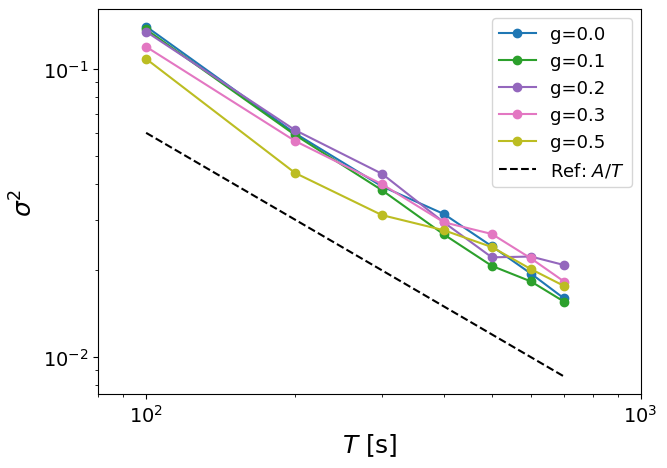

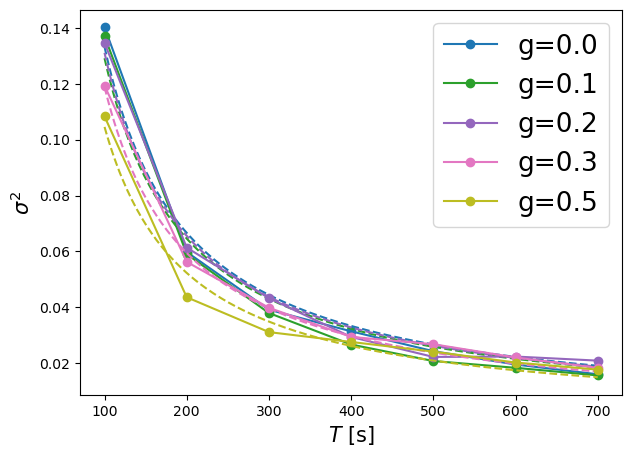

In [ ]:
# Plotting variance of the drift speed distribution ove rtime length of the experiment



T_values = np.arange(100, 701, 100) # experiment lengths used to calculate the variance


dt = 5 * 10**(-3)
grad = np.array([0.1, 1.0, 0.0, 0.3, 0.5, 0.2, 2.0])


pos_data = pos_x[1]
num_T = len(T_values)
num_gradients = pos_data.shape[2]

# Sort gradients and get sorted indices
sorted_indices = np.argsort(grad)
grad_sorted = grad[sorted_indices]

# Initialize arrays
variances_per_gradient = np.zeros((num_gradients, num_T))
experiment_length = []

# calculate the drift speed for the different experiemnt lengths
for t_idx, T in enumerate(T_values):
    T_index = int(T / dt)
    if T_index >= pos_data.shape[0]:
        break

    experiment_length.append(T)

    for i, dir_id in enumerate(sorted_indices):
        if grad[dir_id] in [1.0, 2.0]:
            continue  # skip these gradients

        v_d_T_all = []

        for file_id in range(pos_data.shape[1]):
            pos_initial = pos_data[0, file_id, dir_id]
            pos_final = pos_data[T_index, file_id, dir_id]
            v_d_t = (pos_final - pos_initial) / T
            v_d_T_all.append(v_d_t)

        variances_per_gradient[i, t_idx] = np.var(v_d_T_all) / pos_data.shape[1]


num_curves = len(grad_sorted) - 2  # skip g = 1.0 and 2.0
cmap = plt.cm.get_cmap('tab10') 
colors = [cmap(i / num_curves) for i in range(num_curves)]
# Fit each curve to A/t
from scipy.optimize import curve_fit

def inv_t_model(t, A):
    return A / t
plt.figure(figsize=(7,5))

# Plot data for each gradient
for i, g in enumerate(grad_sorted):
    if g in [1.0, 2.0]:
        continue
    y_data = variances_per_gradient[i, :len(experiment_length)]
    x_data = experiment_length

    plt.plot(
        x_data,
        y_data,
        marker='o',
        color=colors[i],
        label=f'g={g}'
    )

# Plot reference line: A/t
A_ref = 6.0  # adjust this constant as needed for visibility
ref_y = A_ref / t_smooth
plt.plot(
    t_smooth,
    ref_y,
    'k--',
    label=r'Ref: $A/T$'
)

plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1e3)

plt.xlabel(r'$T$ [s]', fontsize = 18)
plt.ylabel(r'$\sigma^2$', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=14)  # Bigger tick labels
plt.legend(fontsize=13)
plt.show()


plt.figure(figsize=(7,5))
for i, g in enumerate(grad_sorted):
    if g in [1.0, 2.0]:
        continue
    y_data = variances_per_gradient[i, :len(experiment_length)]
    x_data = experiment_length

    try:
        popt, _ = curve_fit(inv_t_model, x_data, y_data)
        A_fit = popt[0]

        # Plot data
        plt.plot(
            x_data,
            y_data,
            marker='o',
            color=colors[i],
            label=f'g={g}'
        )

        # Plot fitted curve
        plt.plot(
            t_smooth,
            inv_t_model(t_smooth, A_fit),
            '--',
            color=colors[i]
        )
    except RuntimeError:
        print(f"Fit failed for g={g}")
        continue

plt.xlabel(r'$T$ [s]', fontsize = 15)
plt.ylabel(r'$\sigma^2$', fontsize = 15)
plt.legend(fontsize=19)
#plt.title(r'Fit to $\sigma^2(v_D) = A / t$')
plt.show()

